## Initial setup

In [319]:
# Load necessary libraries
library(tidyverse)
library(syuzhet)
library(wordcloud)
library(tidytext)
library(readxl)
library(tm)

# Load the provided survey data
file_path <- "data/cleanSurveyData20240514.xlsx"
survey_data <- read_excel(file_path)

### Show the column names + index number (survey questions)
From here on we can use the index numbers to refer to the questions.

In [320]:
# Display the column names
print(colnames(survey_data))

 [1] "ID"                                                                                                       
 [2] "Start time"                                                                                               
 [3] "Completion time"                                                                                          
 [4] "Email"                                                                                                    
 [5] "Do you consider yourself a professional or a hobbyist in game development?"                               
 [6] "Primary area of work?"                                                                                    
 [7] "Years of experience in game development?"                                                                 
 [8] "Are you in a lead role?"                                                                                  
 [9] "Team size?"                                                                               

## Count of Professionals vs. Hobbyists

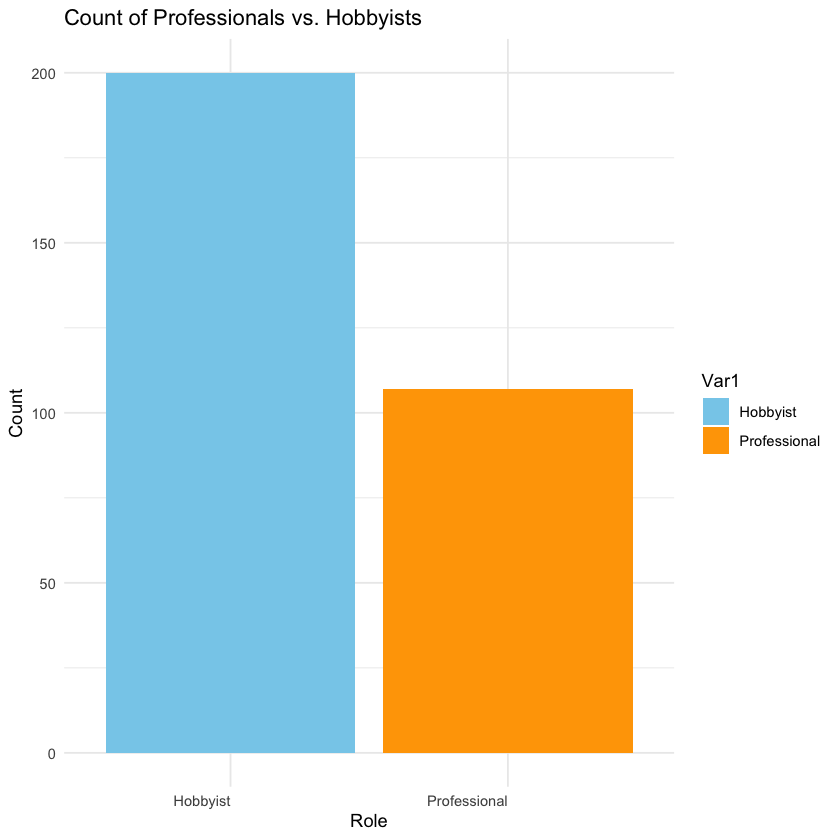

In [321]:
# Fill missing values in 'Do you consider yourself a professional or a hobbyist in game development?'
survey_data[[5]][is.na(survey_data[[5]])] <- "Unknown"

# Descriptive analysis: Count of professionals vs. hobbyists
professional_hobbyist_count <- table(
    survey_data[[5]]
)

# Plotting the count of professionals vs. hobbyists
ggplot(as.data.frame(professional_hobbyist_count), aes(x = Var1, y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Count of Professionals vs. Hobbyists", x = "Role", y = "Count") +
  theme(axis.text.x = element_text(angle = 0, hjust = 1)) +
  scale_fill_manual(values = c(
    "skyblue", 
    "orange", 
    "green", 
    "purple"
    )
    ) # Added more colors to the scale


## Primary area of work

In [322]:
# Show the distribution of 'Primary area of work?' in number of respondents
primary_area_count <- table(survey_data[6])

# Print the raw count of respondents in each primary area of work
primary_area_count

Primary area of work?
                                                                                                                                                                                     Art & Assets 
                                                                                                                                                                                               35 
                                                                                                                                                                                    Audio & Music 
                                                                                                                                                                                                3 
                                                                                                                                                                                   Auto body, lol 
   

### Manual clean up of categories

In [323]:
# Generalists
for (i in c(7, 9, 11, 12)) { # Combine the categories
    primary_area_count[8] <- primary_area_count[8] + primary_area_count[i]
}

# Rename to Generalists
names(primary_area_count)[8] <- "Generalists"

# Other
for (i in c(3, 4, 6, 14)) { # Combine the categories
    primary_area_count[15] <- primary_area_count[15] + primary_area_count[i]
}

# Rename to Other
names(primary_area_count)[15] <- "Other"

# Remove the categories that were combined
primary_area_count <- primary_area_count[-c(7, 9, 11, 12, 3, 4, 6, 14)]

# Output the cleaned up categories
primary_area_count

           Art & Assets           Audio & Music     Design & Production 
                     35                       3                      13 
            Generalists          Marketing & PR Technical & Programming 
                    138                       1                     112 
                  Other 
                      5 

### Visualizing the data

Warning message in dotchart(primary_area_count, labels = paste(names(primary_area_count), :
"'x' is neither a vector nor a matrix: using as.numeric(x)"


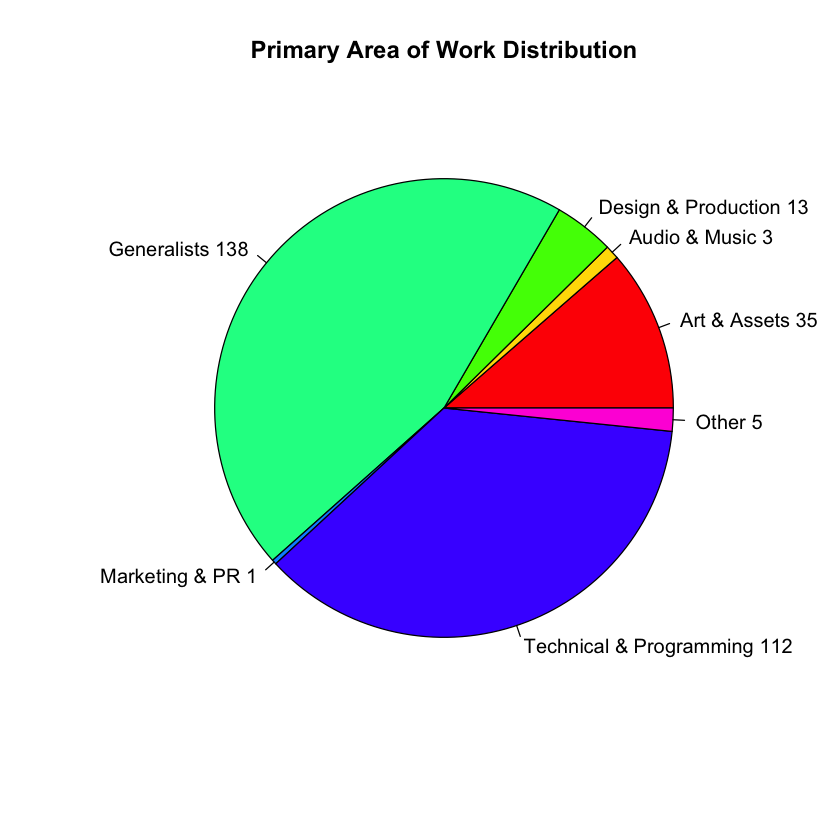

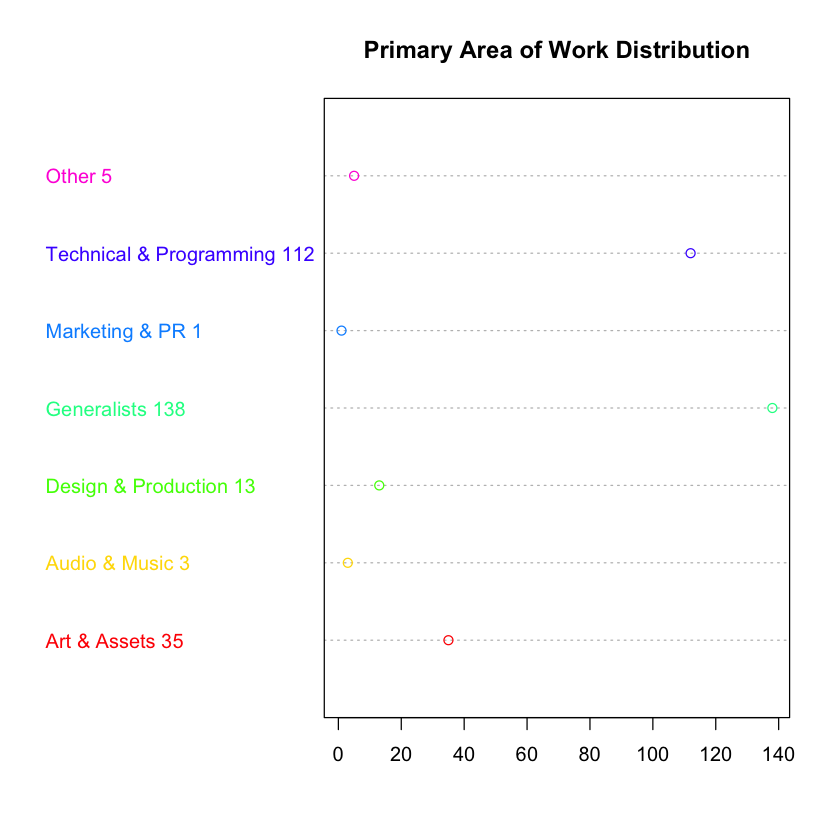

In [336]:
# Distribution of primary areas of work
pie(
    primary_area_count,
    labels = paste(names(primary_area_count), primary_area_count),
    main = "Primary Area of Work Distribution",
    col = rainbow(length(primary_area_count))
)



# And as a dotchart
dotchart(
    primary_area_count,
    labels = paste(names(primary_area_count), primary_area_count),
    main = "Primary Area of Work Distribution",
    col = rainbow(length(primary_area_count))
)

## Distribution of Years of Experience

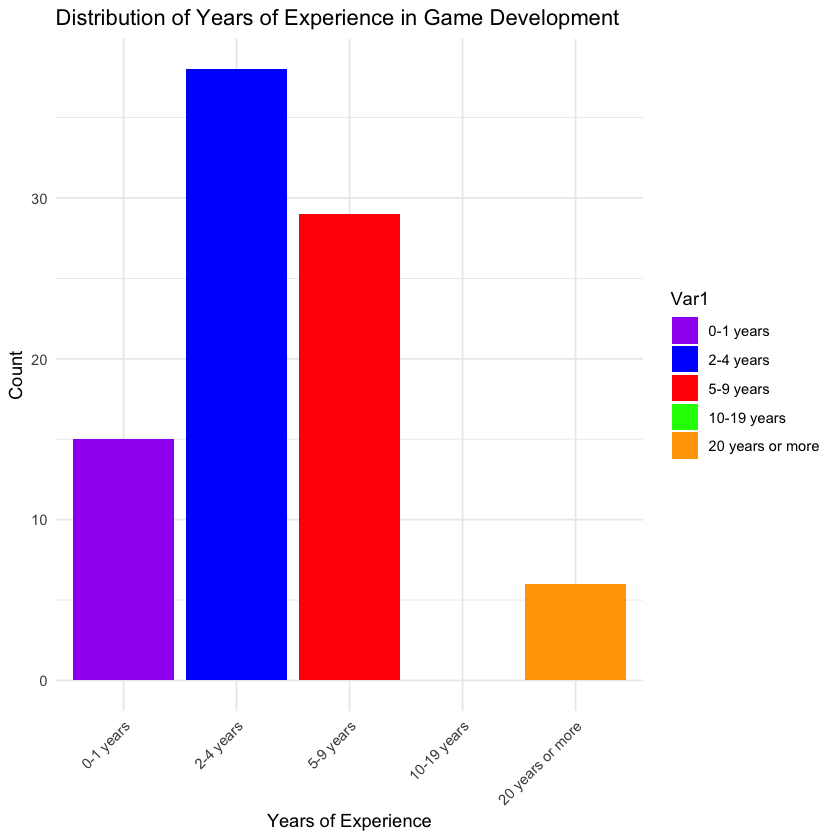

In [325]:
# Define the correct order for the levels
year_levels <- c("0-1 years", "2-4 years", "5-9 years", "10-19 years", "20 years or more")

# Convert the Years of experience column to a factor with specified levels
survey_data[[7]] <- factor(survey_data[[7]], levels = year_levels)

# Filter out 'Unknown' values
filtered_survey_data <- survey_data[!is.na(survey_data[[7]]), ]

# Descriptive analysis: Distribution of years of experience
experience_distribution <- table(filtered_survey_data[[7]])

# Plotting the distribution of years of experience
ggplot(as.data.frame(experience_distribution), aes(x = Var1, y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(
    title = "Distribution of Years of Experience in Game Development", 
    x = "Years of Experience", 
    y = "Count"
    ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = c(
    "purple", 
    "blue", 
    "red", 
    "green", 
    "orange"
    )
)


## Overall Stance on Generative AI

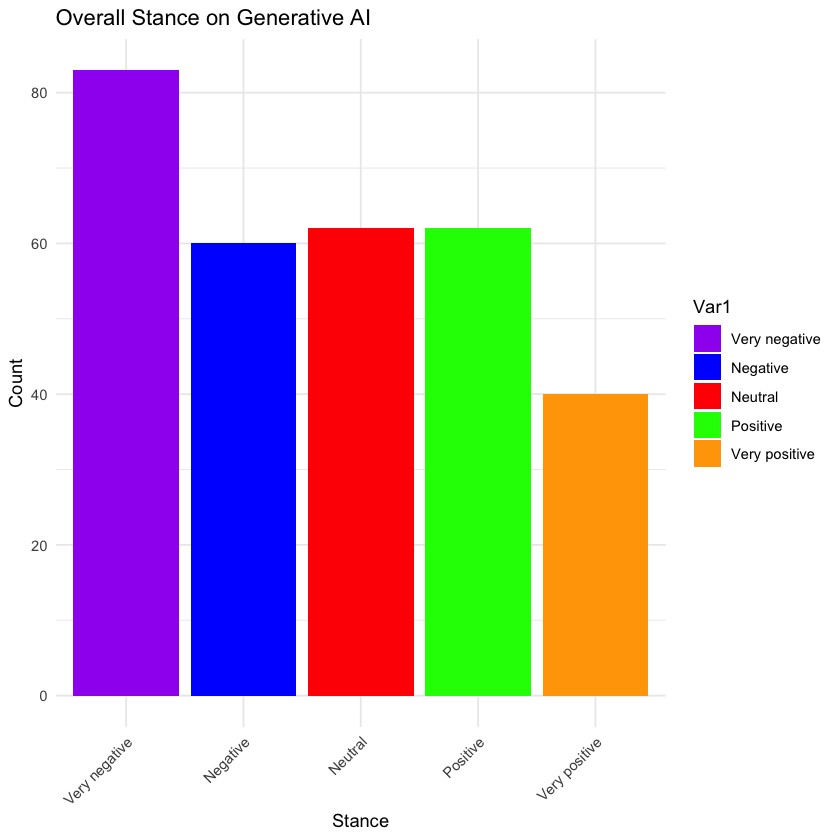

In [326]:
# Define the correct order for the levels
stance_levels <- c(
    "Very negative",
    "Negative",
    "Neutral",
    "Positive",
    "Very positive"
)

# Convert the 'Overall stance on Generative AI?2'
# column to a factor with specified levels
survey_data[[10]] <- factor(survey_data[[10]], levels = stance_levels)

# Exclude 'Unknown' values
filtered_survey_data <- survey_data[!is.na(survey_data[[10]]), ]

# Descriptive analysis: Overall stance on Generative AI
stance_distribution <- table(filtered_survey_data[[10]])

# Plotting the overall stance on Generative AI
ggplot(
    as.data.frame(stance_distribution), 
    aes(x = Var1, y = Freq, fill = Var1)
    ) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Overall Stance on Generative AI", x = "Stance", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(
    values = c(
        "purple", 
        "blue", 
        "red", 
        "green", 
        "orange"
    )
)


## Correlation Analysis

In [327]:
# Convert categorical data to numeric for correlation analysis
survey_data_numeric <- survey_data %>%
  mutate(
    YearsExperience = case_when(
      .[[7]] == "0-1 years" ~ 1,
      .[[7]] == "2-4 years" ~ 2,
      .[[7]] == "5-9 years" ~ 3,
      .[[7]] == "10-19 years" ~ 4,
      .[[7]] == "20 years or more" ~ 5,
      TRUE ~ 0
    ),
    StanceOnGenAI = case_when(
      .[[10]] == "Very positive" ~ 5,
      .[[10]] == "Positive" ~ 4,
      .[[10]] == "Neutral" ~ 3,
      .[[10]] == "Negative" ~ 2,
      .[[10]] == "Very negative" ~ 1,
      TRUE ~ 0
    )
  )

# Calculate correlation
correlation <- cor(
    survey_data_numeric$YearsExperience,
    survey_data_numeric$StanceOnGenAI,
    use = "complete.obs"
)

print(correlation)


[1] -0.055264


noter til corelation
The correlation coefficient of -0.055264 indicates a very weak negative linear relationship between the years of experience in game development and the overall stance on Generative AI among the survey respondents. Here's a more detailed interpretation:

Interpretation:
Magnitude:

The value of -0.055264 is very close to 0, which suggests that there is almost no linear relationship between the two variables.
Direction:

The negative sign indicates that, as the years of experience increase, there is a slight tendency for the stance on Generative AI to become more negative. However, this tendency is very weak.
Practical Significance:

Given the small magnitude of the correlation coefficient, it is unlikely that this relationship has practical significance. In other words, years of experience in game development do not meaningfully predict the overall stance on Generative AI based on the survey data.

## Sentiment Analysis

TILFØJ FLERE


### Wordcloud

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"



                         ai          game         games           art 
           85            67            37            30            26 
       assets    generative    generation   prototyping          code 
           19            18            17            17            15 
         good          make        faster           npc          npcs 
           15            15            13            13            13 
        tools         voice          work   development     generated 
           13            13            13            12            12 
     dialogue          dont       concept    developers        making 
           11            11            10            10            10 
      quality       artists       dynamic         ideas     promising 
           10             9             9             9             9 
      content    generating    innovation        models        people 
            8             8             8             8             8 
     

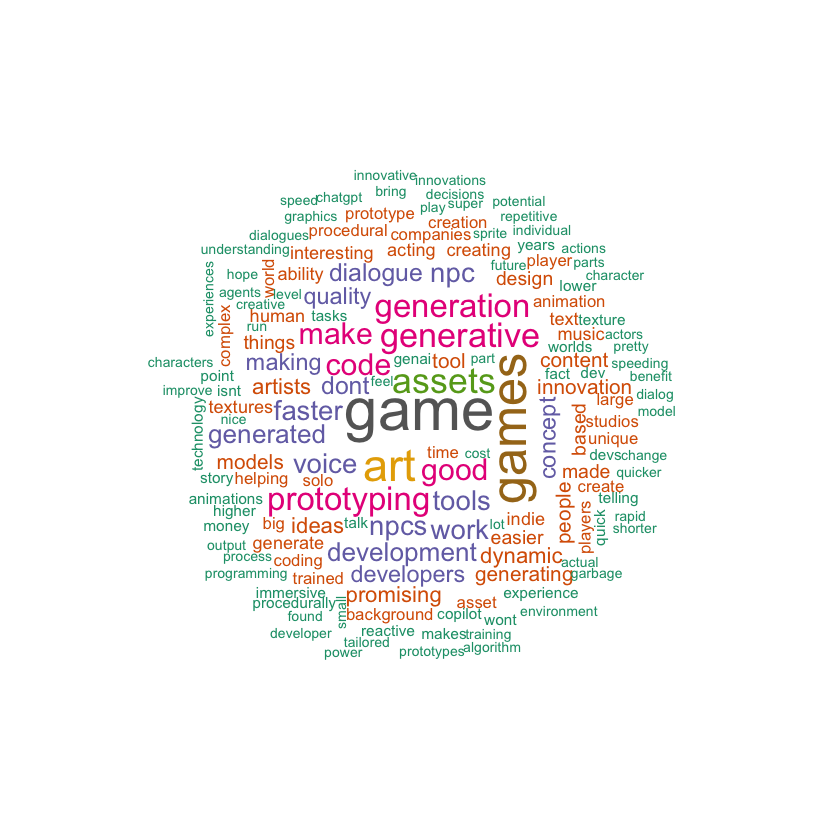

In [337]:
# wordcloud
# Load the text data
wordcloud_data <- survey_data[[45]]

# Preprocess the text data
wordcloud_data <- tolower(wordcloud_data) # Convert to lowercase
wordcloud_data <- removePunctuation(wordcloud_data) # Remove punctuation
wordcloud_data <- removeNumbers(wordcloud_data) # Remove numbers
wordcloud_data <- removeWords(wordcloud_data, stopwords("smart")) # Remove stopwords
wordcloud_data <- stripWhitespace(wordcloud_data) # Remove extra whitespaces

# Create a wordcloud
wordcloud(
    wordcloud_data,
    colors = brewer.pal(8, "Dark2"),
    random.order = FALSE,
    scale = c(3, 0.5)
)

# Show how many times each word appears
word_freq <- table(unlist(strsplit(wordcloud_data, " ")))
word_freq <- sort(word_freq, decreasing = TRUE)
head(decreasing = TRUE, word_freq, 200)


       anger anticipation      disgust         fear          joy      sadness 
          25           85           23           32           85           50 
    surprise        trust     negative     positive 
          65          100           69          236 


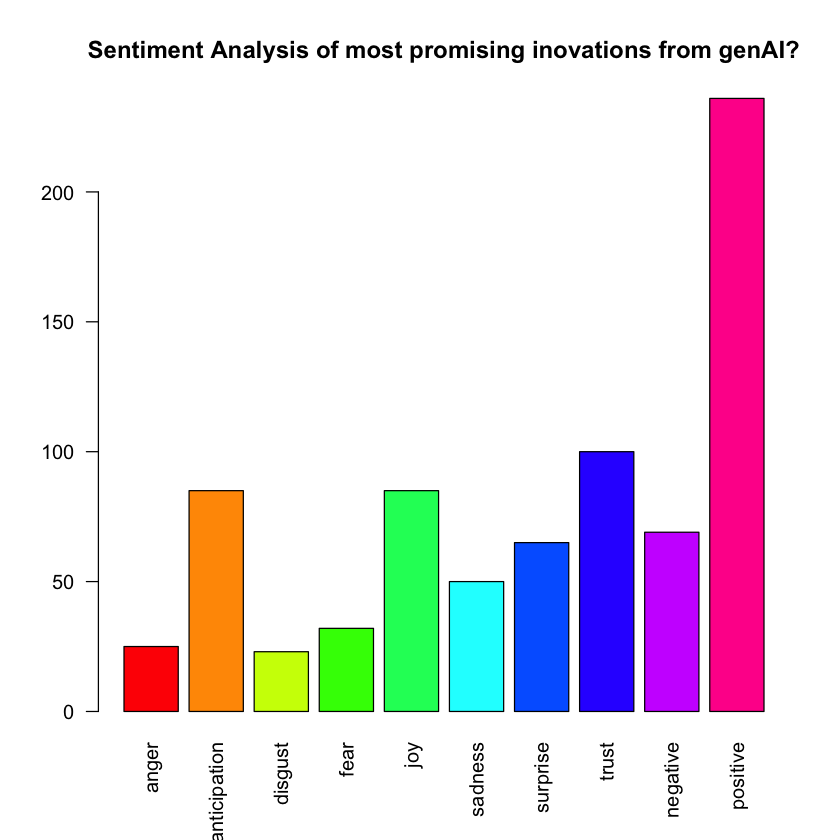

In [338]:
# Extract open-ended responses
open_ended_responses <- survey_data[[45]]
# print(open_ended_responses)

# Perform sentiment analysis
sentiment_scores_0 <- get_nrc_sentiment(open_ended_responses)
# print(sentiment_scores_0)

# Summarize sentiment scores
sentiment_summary_0 <- colSums(sentiment_scores_0)
print(sentiment_summary_0)

# Plot sentiment scores
barplot(sentiment_summary_0, las = 2, col = rainbow(10), main = "Sentiment Analysis of most promising inovations from genAI?")


       anger anticipation      disgust         fear          joy      sadness 
          95          144           71          110          122          148 
    surprise        trust     negative     positive 
          85          140          234          340 


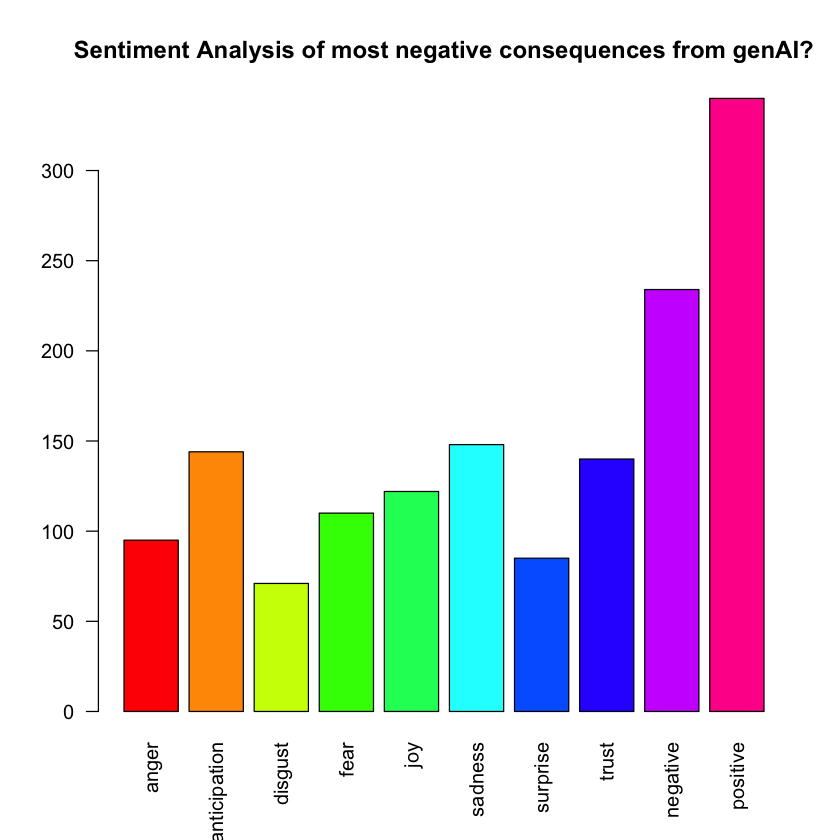

In [339]:
# Extract open-ended responses
open_ended_responses <- survey_data[[46]]

# Perform sentiment analysis
sentiment_scores_1 <- get_nrc_sentiment(open_ended_responses)

# Summarize sentiment scores
sentiment_summary_1 <- colSums(sentiment_scores_1)
print(sentiment_summary_1)

# Plot sentiment scores
barplot(sentiment_summary_1, las = 2, col = rainbow(10), main = "Sentiment Analysis of most negative consequences from genAI?")


       anger anticipation      disgust         fear          joy      sadness 
          24           96           25           36           94           56 
    surprise        trust     negative     positive 
          42          117           75          276 


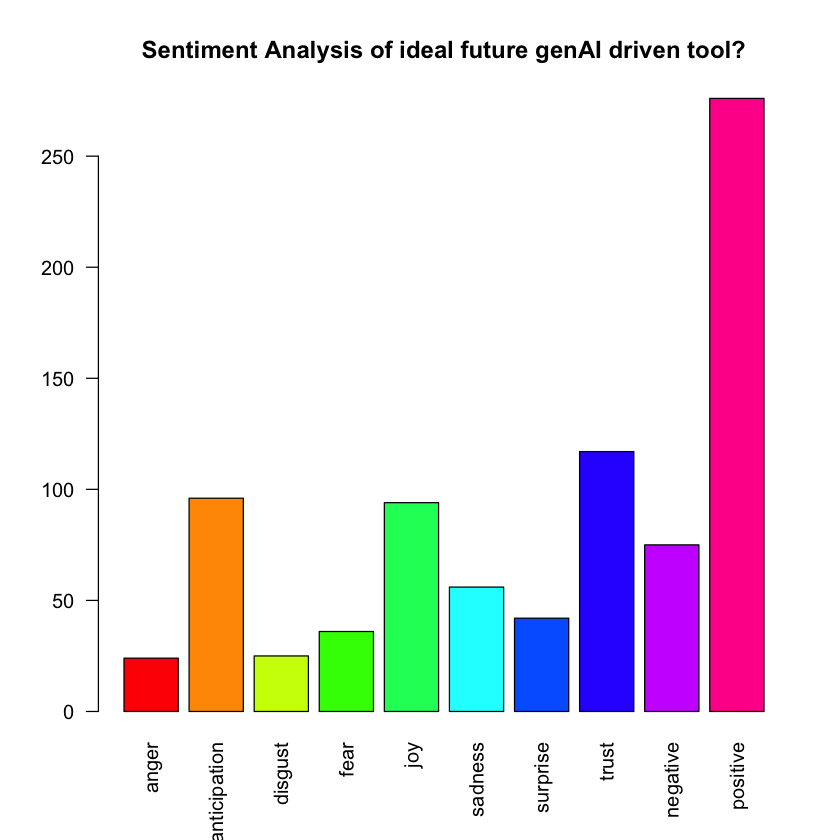

In [340]:
# Extract open-ended responses
open_ended_responses <- survey_data[[50]]

# Perform sentiment analysis
sentiment_scores_2 <- get_nrc_sentiment(open_ended_responses)

# Summarize sentiment scores
sentiment_summary_2 <- colSums(sentiment_scores_2)
print(sentiment_summary_2)

# Plot sentiment scores
barplot(sentiment_summary_2, las = 2, col = rainbow(10), main = "Sentiment Analysis of ideal future genAI driven tool?")


       anger anticipation      disgust         fear          joy      sadness 
          23           59           26           32           43           44 
    surprise        trust     negative     positive 
          29           74           58          145 


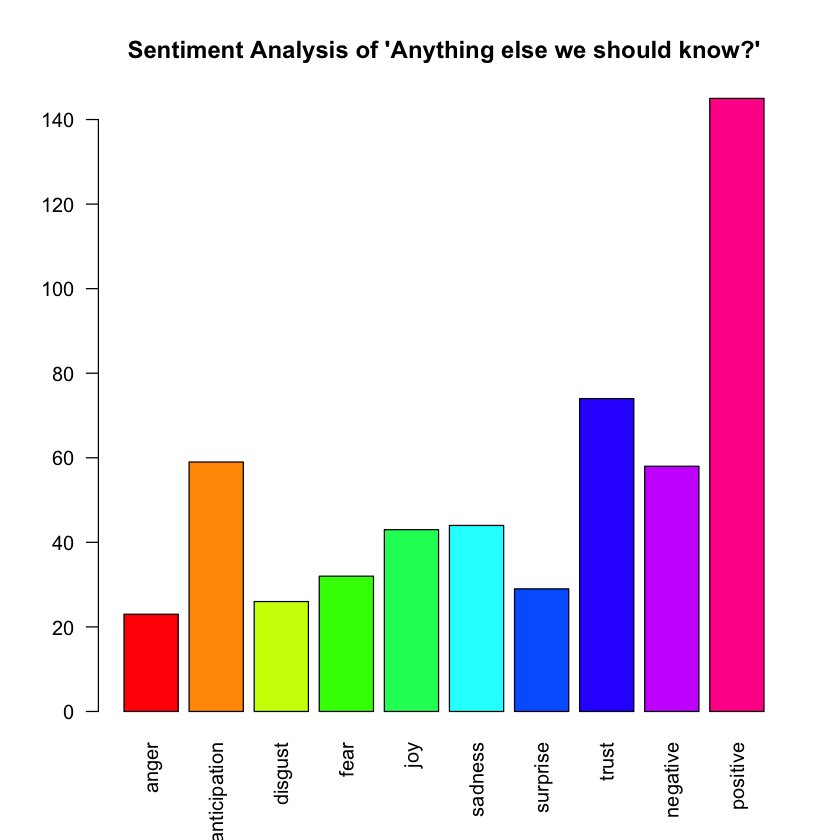

In [342]:
# Extract open-ended responses
open_ended_responses <- survey_data[[52]]

# Perform sentiment analysis
sentiment_scores_3 <- get_nrc_sentiment(open_ended_responses)

# Summarize sentiment scores
sentiment_summary_3 <- colSums(sentiment_scores_3)
print(sentiment_summary_3)

# Plot sentiment scores
barplot(sentiment_summary_3, las = 2, col = rainbow(10), main = "Sentiment Analysis of 'Anything else we should know?'")


## Group Comparisons

In [333]:
# Define the correct order for the levels
stance_levels <- c("Very negative", "Negative", "Neutral", "Positive", "Very positive")

# Convert the 'Overall stance on Generative AI?2' column to a factor with specified levels
survey_data$`Overall stance on Generative AI?2` <- factor(survey_data$`Overall stance on Generative AI?2`, levels = stance_levels)

# Convert categorical data to numeric for stance on Generative AI
survey_data <- survey_data %>%
  mutate(
    StanceOnGenAI = case_when(
      `Overall stance on Generative AI?2` == "Very positive" ~ 5,
      `Overall stance on Generative AI?2` == "Positive" ~ 4,
      `Overall stance on Generative AI?2` == "Neutral" ~ 3,
      `Overall stance on Generative AI?2` == "Negative" ~ 2,
      `Overall stance on Generative AI?2` == "Very negative" ~ 1,
      TRUE ~ NA_real_
    )
  )

# Filter data for professionals and hobbyists
professionals <- survey_data %>% filter(`Do you consider yourself a professional or a hobbyist in game development?` == "Professional")
hobbyists <- survey_data %>% filter(`Do you consider yourself a professional or a hobbyist in game development?` == "Hobbyist")

# Calculate average stance on Generative AI
avg_stance_professionals <- mean(professionals$StanceOnGenAI, na.rm = TRUE)
avg_stance_hobbyists <- mean(hobbyists$StanceOnGenAI, na.rm = TRUE)

print(paste("Average stance on GenAI for professionals:", avg_stance_professionals))
print(paste("Average stance on GenAI for hobbyists:", avg_stance_hobbyists))


[1] "Average stance on GenAI for professionals: 2.5981308411215"
[1] "Average stance on GenAI for hobbyists: 2.795"


Explanation:
Convert Stance to Numeric: The StanceOnGenAI variable is converted to numeric values for easier computation.
Filter Data: Separate the data into professionals and hobbyists based on their response.
Calculate Averages: Compute the average stance for both professionals and hobbyists, excluding any missing values.
This code will give you the average stance on Generative AI for both professionals and hobbyists, allowing you to compare the perspectives of these two groups.

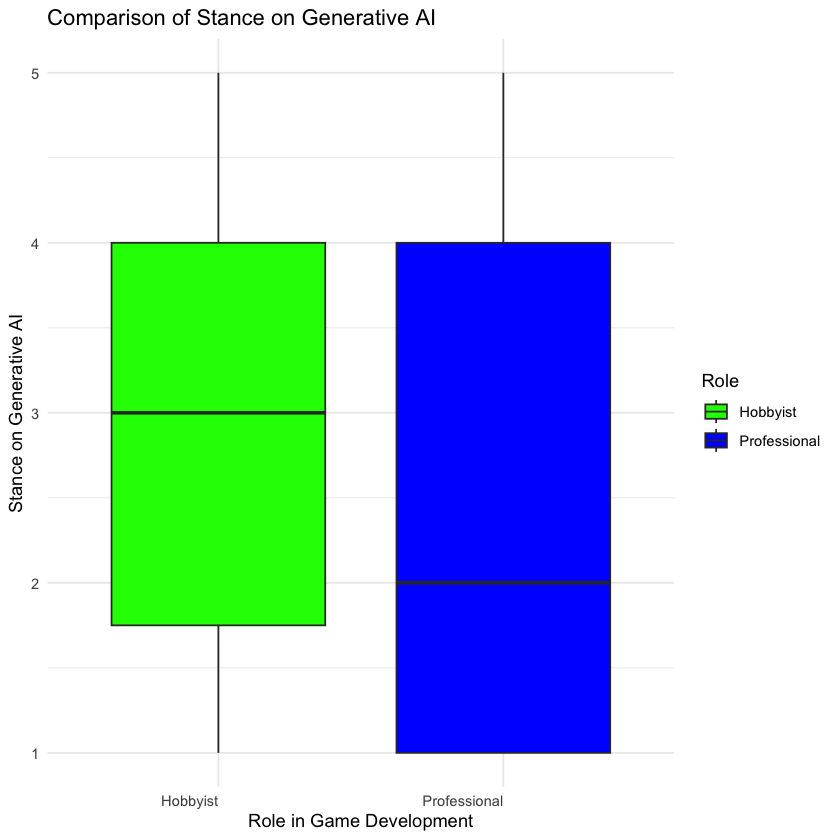

In [334]:
# Filter out unknown roles for clarity
filtered_survey_data <- survey_data %>%
  filter(`Do you consider yourself a professional or a hobbyist in game development?` %in% c("Professional", "Hobbyist"))

# Box plot of Stance on Generative AI for professionals vs. hobbyists
ggplot(filtered_survey_data, aes(x = `Do you consider yourself a professional or a hobbyist in game development?`, y = StanceOnGenAI, fill = `Do you consider yourself a professional or a hobbyist in game development?`)) +
  geom_boxplot() +
  theme_minimal() +
  labs(
    title = "Comparison of Stance on Generative AI",
    x = "Role in Game Development",
    y = "Stance on Generative AI",
    fill = "Role"
  ) +
  scale_fill_manual(values = c("Professional" = "blue", "Hobbyist" = "green")) +
  theme(axis.text.x = element_text(angle = 0, hjust = 1))


Explanation:
Title and Axes:

Title: "Comparison of Stance on Generative AI" clearly indicates the purpose of the plot.
X-axis: "Role in Game Development" differentiates between "Hobbyist" and "Professional".
Y-axis: "Stance on Generative AI" represents the numeric scale of respondents' stances, with 1 being "Very negative" and 5 being "Very positive".
Box Plot Elements:

Boxes: The green box represents hobbyists, and the blue box represents professionals.
Upper and Lower Boundaries of the Box: These represent the 25th (Q1) and 75th (Q3) percentiles, respectively.
Median Line: The horizontal line inside each box represents the median (50th percentile) stance on Generative AI.
Whiskers: The vertical lines extending from the boxes represent the range of the data, excluding outliers. They show the minimum and maximum values within 1.5 times the interquartile range (IQR) from the Q1 and Q3.
Interpretation:

Median: Both hobbyists and professionals have a median stance of 3, which corresponds to a "Neutral" stance on Generative AI.
Interquartile Range (IQR):
Hobbyists: The IQR for hobbyists spans from 2 ("Negative") to 4 ("Positive").
Professionals: The IQR for professionals spans from 2 ("Negative") to 4 ("Positive").
Whiskers:
Both hobbyists and professionals have whiskers extending from 1 ("Very negative") to 5 ("Very positive").
Spread: The spread of responses for both groups is quite similar, indicating a wide range of opinions within both groups, but with a central tendency towards neutrality.
Summary:
The box plot shows that both hobbyists and professionals in game development exhibit a wide range of stances on Generative AI, but on average, both groups tend to have a neutral stance. The distribution of opinions is similar between the two groups, with a slightly broader range observed among hobbyists.

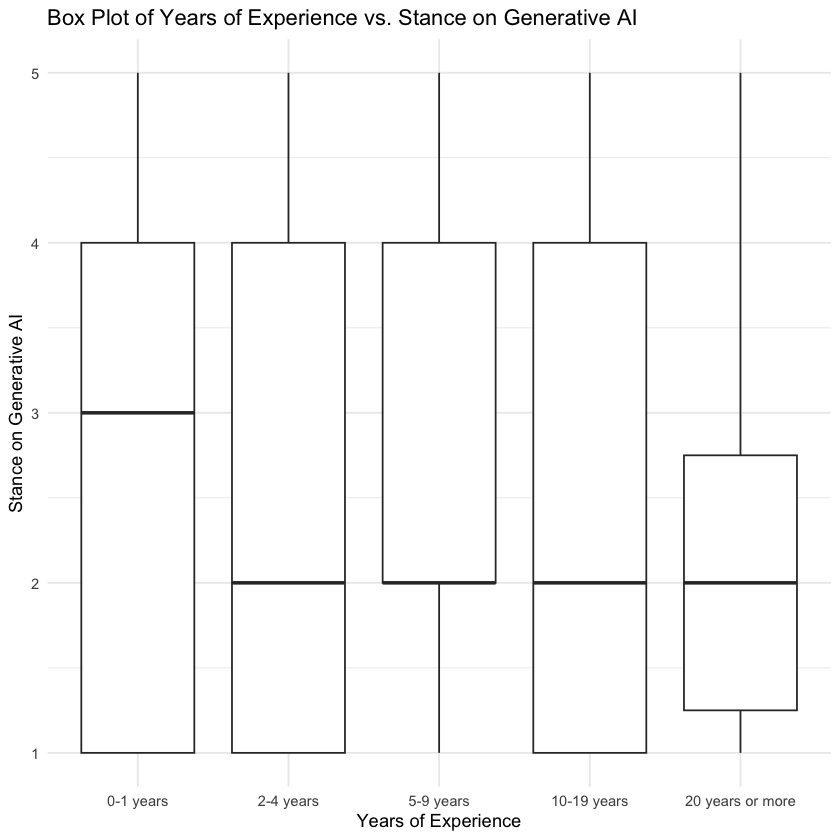

In [335]:
# Box plot of Years of Experience vs. Stance on Generative AI
ggplot(survey_data_numeric, aes(x = factor(YearsExperience, labels = c("0-1 years", "2-4 years", "5-9 years", "10-19 years", "20 years or more")), y = StanceOnGenAI)) +
  geom_boxplot() +
  theme_minimal() +
  labs(
    title = "Box Plot of Years of Experience vs. Stance on Generative AI",
    x = "Years of Experience",
    y = "Stance on Generative AI"
  )


Key Elements:
Title and Axes:

Title: "Box Plot of Years of Experience vs. Stance on Generative AI" indicates the comparison being made.
X-axis: "Years of Experience" shows different experience ranges (0-1 years, 2-4 years, 5-9 years, 10-19 years, 20 years or more).
Y-axis: "Stance on Generative AI" represents the stance, with 1 being "Very negative" and 5 being "Very positive".
Boxes:

Each box represents the distribution of stances within a specific experience range.
Upper and Lower Boundaries: The top and bottom edges of each box represent the 75th percentile (Q3) and 25th percentile (Q1), respectively.
Median Line: The horizontal line within each box indicates the median (50th percentile) stance.
Whiskers:

The lines extending from the top and bottom of each box (whiskers) represent the range of the data within 1.5 times the interquartile range (IQR) from Q1 and Q3.
Any points outside of this range would be considered outliers, but none are shown in this plot.
Insights:
0-1 years:

Median: The median stance is around 3 ("Neutral").
Range: The stances range from 1 ("Very negative") to 5 ("Very positive").
2-4 years:

Median: The median stance is around 3 ("Neutral").
Range: The stances range from 1 ("Very negative") to 5 ("Very positive").
5-9 years:

Median: The median stance is around 3 ("Neutral").
Range: The stances range from 1 ("Very negative") to 5 ("Very positive").
10-19 years:

Median: The median stance is around 3 ("Neutral").
Range: The stances range from 1 ("Very negative") to 5 ("Very positive").
20 years or more:

Median: The median stance is lower, around 2 ("Negative").
Range: The stances range from 1 ("Very negative") to 4 ("Positive").
Summary:
Overall Trend: Across all experience ranges, the median stance is mostly neutral (3), except for those with 20 years or more experience, where the median stance is slightly more negative.
Variability: The stances vary widely within each experience range, covering almost the entire spectrum from very negative to very positive.
Experienced Developers: The most experienced group (20 years or more) tends to have a slightly more negative stance on Generative AI compared to other groups.